In [1]:
# Cell 1: 必要的导入
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor  # 添加AdaBoost回归器
from sklearn.model_selection import KFold, GridSearchCV, train_test_split  # 添加网格搜索和训练集分割
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
import copy
import matplotlib.pyplot as plt  # 用于可视化结果比较

# 抑制警告信息
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)


In [2]:
# Cell 2: TwoStageTrAdaBoostR2 算法定义 (修复版)
################################################################################
## Stage2_TrAdaBoostR2: 对应原始代码的内部 AdaBoost.R2 变体
################################################################################
class Stage2_TrAdaBoostR2:
    def __init__(self,
                 base_estimator=DecisionTreeRegressor(max_depth=4),
                 sample_size=None, # [n_source_samples_in_combined_data, n_target_samples_in_combined_data]
                 n_estimators=50,
                 learning_rate=1.,
                 loss='linear',
                 random_state=None): #修复随机状态处理
        self.base_estimator = base_estimator
        self.sample_size = sample_size # 非常重要，用于区分组合数据中的源和目标
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.loss = loss
        
        # 修复随机状态处理
        if random_state is None:
            self.random_state = np.random.mtrand._rand
        elif isinstance(random_state, int):
            self.random_state = np.random.RandomState(random_state)
        else:
            self.random_state = random_state


    def fit(self, X, y, sample_weight=None):
        # Check parameters
        if self.learning_rate <= 0:
            raise ValueError("learning_rate must be greater than zero")

        if sample_weight is None:
            # Initialize weights to 1 / n_samples
            sample_weight = np.empty(X.shape[0], dtype=np.float64)
            sample_weight[:] = 1. / X.shape[0]
        else:
            # Normalize existing weights
            sample_weight = sample_weight / sample_weight.sum(dtype=np.float64)

            # Check that the sample weights sum is positive
            if sample_weight.sum() <= 0:
                raise ValueError(
                      "Attempting to fit with a non-positive "
                      "weighted number of samples.")

        if self.sample_size is None:
            raise ValueError("Stage2_TrAdaBoostR2: sample_size of source and target is missing")
        elif np.array(self.sample_size).sum() != X.shape[0]:
            raise ValueError("Stage2_TrAdaBoostR2: The specified sample_size does not equal to the input X's shape")

        # Clear any previous fit results
        self.estimators_ = []
        self.estimator_weights_ = np.zeros(self.n_estimators, dtype=np.float64)
        self.estimator_errors_ = np.ones(self.n_estimators, dtype=np.float64)

        for iboost in range(self.n_estimators):
            # Boosting step
            sample_weight, estimator_weight, estimator_error = self._stage2_adaboostR2(
                    iboost,
                    X, y,
                    sample_weight)
            
            if estimator_weight is None: # Indicates an early stop from _stage2_adaboostR2
                self.n_estimators = iboost # effective number of estimators
                self.estimator_weights_ = self.estimator_weights_[:iboost]
                self.estimator_errors_ = self.estimator_errors_[:iboost]
                if iboost == 0 and not self.estimators_: # No valid estimator was added
                    # This can happen if the first estimator is discarded.
                    # Add a dummy estimator or handle appropriately.
                    # For now, let's allow it to proceed, predict might need safety for empty estimators_.
                    pass
                break
            
            self.estimators_.append(self.temp_estimator_) # Store the estimator from _stage2_adaboostR2
            self.estimator_weights_[iboost] = estimator_weight
            self.estimator_errors_[iboost] = estimator_error

            # Stop if error is zero
            if estimator_error == 0:
                self.n_estimators = iboost + 1
                self.estimator_weights_ = self.estimator_weights_[:(iboost+1)]
                self.estimator_errors_ = self.estimator_errors_[:(iboost+1)]
                break

            sample_weight_sum = np.sum(sample_weight)

            # Stop if the sum of sample weights has become non-positive
            if sample_weight_sum <= 0:
                self.n_estimators = iboost + 1
                self.estimator_weights_ = self.estimator_weights_[:(iboost+1)]
                self.estimator_errors_ = self.estimator_errors_[:(iboost+1)]
                break

            if iboost < self.n_estimators - 1:
                # Normalize
                sample_weight /= sample_weight_sum
        return self


    def _stage2_adaboostR2(self, iboost, X, y, sample_weight):
        # 检查样本权重
        if np.sum(sample_weight) <= 0 or np.isnan(sample_weight).any():
            warnings.warn("样本权重异常，重新初始化为均匀权重")
            sample_weight = np.ones(X.shape[0]) / X.shape[0]
            
        self.temp_estimator_ = copy.deepcopy(self.base_estimator)

        # Weighted sampling of the training set with replacement (Bootstrap)
        cdf = np.cumsum(sample_weight)
        cdf /= cdf[-1] # Normalize cdf
        uniform_samples = self.random_state.random_sample(X.shape[0])
        bootstrap_idx = cdf.searchsorted(uniform_samples, side='right')
        bootstrap_idx = np.array(bootstrap_idx, copy=False)

        # Fit on the bootstrapped sample
        self.temp_estimator_.fit(X[bootstrap_idx], y[bootstrap_idx])
        y_predict = self.temp_estimator_.predict(X) # Predict on the *whole* dataset X

        error_vect = np.abs(y_predict - y)
        error_max = error_vect.max()

        if error_max != 0.:
            error_vect /= error_max
        # else: all errors are 0, error_vect remains all 0s

        if self.loss == 'square':
            error_vect **= 2
        elif self.loss == 'exponential':
            error_vect = 1. - np.exp(-error_vect)
        # Default is 'linear', already handled by normalization if error_max !=0

        # Calculate the average loss for all samples
        estimator_error = (sample_weight * error_vect).sum()

        if estimator_error <= 0: # Perfect fit or no error
            # Stop if fit is perfect
            return sample_weight, 1., 0. # weight, error

        elif estimator_error >= 0.5:
            # Discard current estimator only if it isn't the only one potentially being trained
            # The original paper implies discarding. If it's the first, it causes issues.
            # Let's signal to outer loop to stop or handle
            if iboost > 0 or len(self.estimators_) >0 : # Check if there are previous estimators
                 pass # Outer loop will handle not adding this estimator if estimator_weight is None
            # If it's the very first estimator and it's bad, we might have issues.
            # The original code allowed self.estimators_.pop(-1) if len > 1.
            # Here, we return None to signal discard to the fit loop.
            return None, None, None # Signal to discard

        beta = estimator_error / (1. - estimator_error)

        if beta < 1e-308: # avoid overflow for 1/beta
            beta = 1e-308
        estimator_weight = self.learning_rate * np.log(1. / beta)

        # AdaBoost.R2 weight update: Update weights of TARGET samples
        # Source sample weights are adjusted to keep total source vs target weight proportion somewhat stable
        
        # Store sum of weights for source and target before target update
        source_weight_sum_before = np.sum(sample_weight[:-self.sample_size[-1]])
        target_weight_sum_before = np.sum(sample_weight[-self.sample_size[-1]:])
        total_weight_before = source_weight_sum_before + target_weight_sum_before


        if not iboost == self.n_estimators - 1: # Don't update weights for the last estimator
            # Update target sample weights
            power_val = (1. - error_vect[-self.sample_size[-1]:]) * self.learning_rate
            # Ensure beta is not 0 to prevent issues with 0^positive_power = 0
            safe_beta = beta if beta > 0 else 1e-308 
            sample_weight[-self.sample_size[-1]:] *= np.power(safe_beta, power_val)

            # Rescale source and target weights to maintain their relative sum proportions
            # This is a crucial part from the original "Boosting for Regression Transfer" paper's Stage 2 adaptation
            source_weight_sum_after_target_update = np.sum(sample_weight[:-self.sample_size[-1]])
            target_weight_sum_after_target_update = np.sum(sample_weight[-self.sample_size[-1]:])
            
            current_total_weight = source_weight_sum_after_target_update + target_weight_sum_after_target_update

            if current_total_weight > 0 and total_weight_before > 0:
                # Desired proportion for source based on *before* update
                desired_source_total_w = (source_weight_sum_before / total_weight_before) * current_total_weight
                # Desired proportion for target based on *before* update
                desired_target_total_w = (target_weight_sum_before / total_weight_before) * current_total_weight

                if source_weight_sum_after_target_update > 0:
                    sample_weight[:-self.sample_size[-1]] *= (desired_source_total_w / source_weight_sum_after_target_update)
                elif desired_source_total_w > 0 and len(sample_weight[:-self.sample_size[-1]]) > 0: # All source weights became zero
                     sample_weight[:-self.sample_size[-1]] = desired_source_total_w / len(sample_weight[:-self.sample_size[-1]])


                if target_weight_sum_after_target_update > 0:
                    sample_weight[-self.sample_size[-1]:] *= (desired_target_total_w / target_weight_sum_after_target_update)
                elif desired_target_total_w > 0 and len(sample_weight[-self.sample_size[-1]:]) > 0: # All target weights became zero
                     sample_weight[-self.sample_size[-1]:] = desired_target_total_w / len(sample_weight[-self.sample_size[-1]:])
            
            # Final normalization will happen in the .fit() loop
            
        return sample_weight, estimator_weight, estimator_error


    def predict(self, X):
        # 添加对self.estimators_的更严格检查
        if not hasattr(self, 'estimators_') or len(self.estimators_) == 0:
            warnings.warn("模型没有有效的估计器，返回零数组")
            return np.zeros(X.shape[0])

        # Ensure estimator_weights_ are for the actual number of estimators
        active_estimator_weights = self.estimator_weights_[:len(self.estimators_)]

        if len(active_estimator_weights) == 0 or np.sum(active_estimator_weights) == 0:
            # If all weights are zero, use simple mean of predictions
            predictions = np.array([est.predict(X) for est in self.estimators_]).T
            if predictions.size == 0: return np.zeros(X.shape[0])
            return np.mean(predictions, axis=1) if predictions.ndim > 1 else np.mean(predictions)


        # Evaluate predictions of all estimators
        predictions = np.array([
                est.predict(X) for est in self.estimators_]).T # Shape (n_samples, n_estimators)

        # Sort the predictions
        sorted_idx = np.argsort(predictions, axis=1)

        # Find index of median prediction for each sample
        # Use active_estimator_weights corresponding to self.estimators_
        weight_cdf = np.cumsum(active_estimator_weights[sorted_idx], axis=1)
        
        # Ensure cdf last element is not zero to avoid division by zero
        # And that weight_cdf has the correct shape for broadcasting
        # Total weight for cdf normalization
        total_estimator_weight = weight_cdf[:, -1][:, np.newaxis]
        # Prevent division by zero if total weight is zero
        total_estimator_weight[total_estimator_weight == 0] = 1.0


        median_or_above = weight_cdf >= 0.5 * total_estimator_weight
        median_idx = median_or_above.argmax(axis=1)

        # Handle cases where median_idx might be out of bounds if predictions array is smaller
        # This shouldn't happen if sorted_idx and predictions are consistent
        
        # Create an index for selecting from predictions array
        # For each sample (row), select the prediction from the estimator at median_estimators[sample_idx]
        median_estimators_indices = sorted_idx[np.arange(X.shape[0]), median_idx]

        # Return median predictions
        return predictions[np.arange(X.shape[0]), median_estimators_indices]


################################################################################
## TwoStageTrAdaBoostR2: The main two-stage algorithm
################################################################################
class TwoStageTrAdaBoostR2:
    def __init__(self,
                 base_estimator=DecisionTreeRegressor(max_depth=4),
                 sample_size=None, # [n_source_total, n_target_train] for the combined X, y passed to fit
                 n_estimators=10, # Number of estimators for Stage2 model
                 steps=10, # Number of iterations for Stage1 (source re-weighting)
                 fold=5, # CV folds for Stage1 model selection
                 learning_rate=1., # Learning rate for Stage1 source weight update
                 loss='linear', # Loss function for Stage2
                 random_state=None):
        self.base_estimator = base_estimator
        self.sample_size = sample_size # Defines split of combined X,y into source and target
        self.n_estimators_stage2 = n_estimators # Renamed to avoid confusion
        self.steps = steps
        self.fold = fold
        self.learning_rate_stage1 = learning_rate # Renamed
        self.loss_stage2 = loss # Renamed
        
        # 修复随机状态处理
        if random_state is None:
            self.random_state = np.random.mtrand._rand
        elif isinstance(random_state, int):
            self.random_state = np.random.RandomState(random_state)
        else:
            self.random_state = random_state

    def fit(self, X, y, sample_weight_init=None): # X, y are combined source and target data
        # Check parameters
        if self.learning_rate_stage1 <= 0:
            raise ValueError("learning_rate_stage1 must be greater than zero")

        if self.sample_size is None:
            raise ValueError("TwoStageTrAdaBoostR2: sample_size of source and target is missing")
        elif not isinstance(self.sample_size, list) or len(self.sample_size) != 2:
             raise ValueError("TwoStageTrAdaBoostR2: sample_size should be a list of two integers [n_source, n_target]")
        elif np.array(self.sample_size).sum() != X.shape[0]:
            raise ValueError("TwoStageTrAdaBoostR2: The specified sample_size sum does not equal to the input X's shape")
        
        n_source = self.sample_size[0]
        n_target = self.sample_size[1]

        if sample_weight_init is None:
            # Initialize weights to 1 / n_samples for the combined dataset
            current_sample_weight = np.empty(X.shape[0], dtype=np.float64)
            current_sample_weight[:] = 1. / X.shape[0]
        else:
            current_sample_weight = sample_weight_init / sample_weight_init.sum(dtype=np.float64)
            if current_sample_weight.sum() <= 0:
                raise ValueError("Attempting to fit with a non-positive weighted number of samples.")

        # Data splitting for CV (target data) and for source data reference
        X_source = X[:n_source]
        y_source = y[:n_source]
        X_target = X[n_source:]
        y_target = y[n_source:]

        self.models_ = [] # Stores Stage2_TrAdaBoostR2 models from each step
        self.errors_ = [] # Stores CV errors for each model in models_

        for istep in range(self.steps):
            # Train Stage2 model on current weighted combined data
            stage2_model = Stage2_TrAdaBoostR2(
                base_estimator=copy.deepcopy(self.base_estimator), # Use a copy for each Stage2 model
                sample_size=self.sample_size, # Pass the original [n_source, n_target]
                n_estimators=self.n_estimators_stage2,
                learning_rate=1.0, # Stage2 LR usually 1, or could be a param
                loss=self.loss_stage2,
                random_state=self.random_state
            )
            stage2_model.fit(X, y, sample_weight=current_sample_weight)
            self.models_.append(stage2_model)

            # Cross-validation on TARGET data to evaluate the current stage2_model's utility for Stage1
            # The CV here is to find the error of a model trained on source+target(train_fold) on target(test_fold)
            kf = KFold(n_splits=self.fold, shuffle=True, random_state=self.random_state if isinstance(self.random_state, np.random.RandomState) else None)
            cv_errors_for_current_step = []
            
            # Weights for CV: source part from current_sample_weight, target part from current_sample_weight
            source_weights_for_cv = current_sample_weight[:n_source]
            target_weights_for_cv = current_sample_weight[n_source:]

            if n_target < self.fold : # Cannot perform KFold if n_target is too small
                 warnings.warn(f"Target sample size ({n_target}) is less than K ({self.fold}). CV error might be unstable or averaging over fewer effective folds.")
                 # Fallback: could use error on whole target set, or skip CV error calculation.
                 # For now, if KFold fails, this loop won't run, cv_errors_for_current_step will be empty.
                 # Add a check later for empty cv_errors_for_current_step.
                 if n_target > 0: # if target data exists, use full target set for error
                    y_pred_target = stage2_model.predict(X_target)
                    cv_errors_for_current_step.append(mean_squared_error(y_target, y_pred_target))


            for train_idx_target, test_idx_target in kf.split(X_target):
                # Prepare data for this CV fold
                X_target_train_fold, X_target_test_fold = X_target[train_idx_target], X_target[test_idx_target]
                y_target_train_fold, y_target_test_fold = y_target[train_idx_target], y_target[test_idx_target]

                X_cv_train = np.concatenate((X_source, X_target_train_fold))
                y_cv_train = np.concatenate((y_source, y_target_train_fold))
                
                # Sample weights for this CV fold
                target_weights_train_fold = target_weights_for_cv[train_idx_target]
                # Normalize target_weights_train_fold to sum to what it represented in target_weights_for_cv
                if np.sum(target_weights_train_fold) > 0 and np.sum(target_weights_for_cv) > 0 :
                     target_weights_train_fold_adj = target_weights_train_fold * (np.sum(target_weights_for_cv) / np.sum(target_weights_train_fold))
                else: # if sum is zero, distribute uniformly or handle
                     target_weights_train_fold_adj = np.ones_like(target_weights_train_fold) / len(target_weights_train_fold) if len(target_weights_train_fold) > 0 else np.array([])


                cv_sample_weight = np.concatenate((source_weights_for_cv, target_weights_train_fold_adj))
                if np.sum(cv_sample_weight) > 0:
                    cv_sample_weight /= np.sum(cv_sample_weight)
                else: # All weights are zero, reinitialize uniformly
                    cv_sample_weight = np.ones_like(cv_sample_weight) / len(cv_sample_weight) if len(cv_sample_weight) > 0 else np.array([])


                # Train a temporary Stage2 model for this CV fold
                temp_cv_stage2_model = Stage2_TrAdaBoostR2(
                    base_estimator=copy.deepcopy(self.base_estimator),
                    sample_size=[n_source, len(X_target_train_fold)], # size for this CV model
                    n_estimators=self.n_estimators_stage2,
                    learning_rate=1.0,
                    loss=self.loss_stage2,
                    random_state=self.random_state
                )
                if len(X_cv_train) > 0 and len(cv_sample_weight) == len(X_cv_train):
                    temp_cv_stage2_model.fit(X_cv_train, y_cv_train, sample_weight=cv_sample_weight)
                    y_pred_cv_test = temp_cv_stage2_model.predict(X_target_test_fold)
                    cv_errors_for_current_step.append(mean_squared_error(y_target_test_fold, y_pred_cv_test))
                elif len(X_target_test_fold) > 0 : # Cannot train, but if test exists, append high error
                     cv_errors_for_current_step.append(np.inf)


            if not cv_errors_for_current_step: # If CV couldn't run (e.g. n_target too small)
                # Use error of the main stage2_model on the whole target set as a fallback
                if n_target > 0:
                    y_pred_target_fallback = stage2_model.predict(X_target)
                    current_step_error = mean_squared_error(y_target, y_pred_target_fallback)
                else: # No target data to evaluate, this is problematic for TrAdaBoost
                    current_step_error = np.inf 
                warnings.warn(f"CV for step {istep} did not produce errors, using fallback error: {current_step_error}")

            else:
                current_step_error = np.mean(cv_errors_for_current_step)
            self.errors_.append(current_step_error)

            # Update SOURCE sample weights using _twostage_adaboostR2 logic
            # This method modifies current_sample_weight inplace or returns new one
            updated_weights_from_stage1 = self._twostage_adaboostR2_source_reweight(
                istep, X, y, current_sample_weight
            )
            
            if updated_weights_from_stage1 is None: # Indicates an issue in source re-weighting
                warnings.warn(f"Source re-weighting failed at step {istep}. Stopping.")
                self.steps = istep # effective steps
                break 
            current_sample_weight = updated_weights_from_stage1


            if current_step_error == 0 and istep > 0: # istep > 0 to allow at least one model
                warnings.warn(f"CV error is 0 at step {istep}. Early stopping.")
                self.steps = istep + 1
                break

            current_sample_weight_sum = np.sum(current_sample_weight)
            if current_sample_weight_sum <= 0:
                warnings.warn(f"Sum of sample weights is non-positive at step {istep}. Stopping.")
                self.steps = istep + 1
                break
            
            if istep < self.steps - 1: # Normalize for next iteration, unless it's the last
                current_sample_weight /= current_sample_weight_sum
        
        if not self.models_:
            raise RuntimeError("TwoStageTrAdaBoostR2: No models were trained. Check data and parameters.")
        return self


    def _twostage_adaboostR2_source_reweight(self, istep, X, y, sample_weight):
        # 添加权重检查
        if np.sum(sample_weight) <= 0 or np.isnan(sample_weight).any():
            warnings.warn("源域权重更新前的样本权重异常，重新初始化")
            sample_weight = np.ones(X.shape[0]) / X.shape[0]
            
        # This part is for updating SOURCE data weights based on Algorithm 3 (outer loop)
        n_source = self.sample_size[0]
        
        # Train a temporary base estimator on combined data with current weights
        # Using weighted sampling as per Drucker's paper suggestion for AdaBoost.R2 context
        temp_base_model_for_error = copy.deepcopy(self.base_estimator)
        
        cdf = np.cumsum(sample_weight)
        if cdf[-1] == 0 : # all weights are zero
            warnings.warn("All sample weights are zero in _twostage_adaboostR2_source_reweight. Cannot proceed.")
            return None # Signal failure
        cdf /= cdf[-1]
        uniform_samples = self.random_state.random_sample(X.shape[0])
        bootstrap_idx = cdf.searchsorted(uniform_samples, side='right')
        bootstrap_idx = np.array(bootstrap_idx, copy=False)

        temp_base_model_for_error.fit(X[bootstrap_idx], y[bootstrap_idx])
        y_predict = temp_base_model_for_error.predict(X)

        error_vect = np.abs(y_predict - y) # Absolute error on all combined data
        error_max = error_vect.max()
        if error_max != 0.:
            error_vect /= error_max
        # if error_max is 0, error_vect is all 0s

        # For TrAdaBoost (Algorithm 3), source weights are updated.
        # Need to find beta_t (here, beta_stage1) using binary search.
        # This beta_stage1 aims to adjust target data's total weight to a theoretical value.
        
        beta_stage1 = self._beta_binary_search(istep, sample_weight, error_vect, stp=1e-30)

        # Update SOURCE sample weights
        if not istep == self.steps - 1: # Don't update for the last step
            # error_vect_source is the normalized error for source instances
            error_vect_source = error_vect[:n_source] 
            # Original paper: W_{t+1}(i) = W_t(i) * beta_t ^ ( |h_t(x_i) - f_S(x_i)| / D_t ) for TrAdaBoost.
            # The provided code does: sample_weight[:-n_source] *= beta ^ (error_vect_source * LR)
            # This means higher error on source with beta < 1 leads to lower weight.
            # Ensure beta_stage1 is not exactly 0 if power is non-zero to avoid 0^positive_power = 0
            safe_beta_stage1 = beta_stage1 if beta_stage1 > 0 else 1e-308

            power_term = error_vect_source * self.learning_rate_stage1
            sample_weight[:n_source] *= np.power(safe_beta_stage1, power_term)
        
        return sample_weight


    def _beta_binary_search(self, istep, sample_weight_original, error_vect, stp):
        # 添加对sample_weight_original的检查
        if np.sum(sample_weight_original) == 0:
            warnings.warn("所有样本权重为零，无法进行beta二分查找")
            return 0.5  # 返回一个中间值作为回退策略
            
        # This beta is for Stage 1 source re-weighting.
        # It adjusts source weights such that the *proportion* of target weights reaches a target.
        n_source = self.sample_size[0]
        n_target = self.sample_size[1]
        
        if n_source + n_target == 0: return 0. # Avoid division by zero
        
        # Theoretical sum of TARGET weights (proportion) after normalization
        # This sum increases with istep
        if self.steps <= 1: # Avoid division by zero if steps is 1
            theoretical_target_weight_proportion = n_target / (n_source + n_target) if (n_source + n_target) > 0 else 0.5
        else:
            theoretical_target_weight_proportion = (n_target / (n_source + n_target) +
                                               istep / (self.steps - 1) * (1 - n_target / (n_source + n_target)))

        if istep == self.steps - 1: # For the last iteration, beta is 0 (no more source re-weighting for next)
            return 0.

        L, R = 0., 1.
        beta_candidate = (L + R) / 2.0
        
        for _ in range(100): # Max 100 iterations for binary search, or until condition met
            sample_weight_temp = copy.deepcopy(sample_weight_original)
            
            # Tentatively update SOURCE weights with current beta_candidate
            error_vect_source = error_vect[:n_source]
            safe_beta_candidate = beta_candidate if beta_candidate > 0 else 1e-308
            power_term = error_vect_source * self.learning_rate_stage1
            sample_weight_temp[:n_source] *= np.power(safe_beta_candidate, power_term)
            
            # Normalize the temporarily updated weights
            if np.sum(sample_weight_temp) > 0:
                sample_weight_temp /= np.sum(sample_weight_temp)
            else: # All weights became zero, problem with beta_candidate or errors
                # If beta is 0 and all errors are high, this could happen.
                # This case suggests beta_candidate might be too small if errors are large.
                # Or if original weights were zero.
                # If beta_candidate is 0, updated_target_weight_proportion would be sum(original_target_weights)/sum(original_weights)
                # if beta_candidate is 1, it's the same.
                # Let's assume non-zero sum for original, if temp sum is 0, it's likely due to beta_candidate being 0.
                if beta_candidate < 1e-10 : # if beta is essentially 0
                    current_target_weight_proportion = np.sum(sample_weight_original[n_source:]) / np.sum(sample_weight_original) if np.sum(sample_weight_original) > 0 else 0
                else: # Some other issue, maybe errors are too extreme.
                    # This part is tricky. If all weights are zero, target proportion is ill-defined.
                    # This usually means beta made source weights zero.
                    # If source weights are zero, target proportion is 1 (if target weights >0) or NaN.
                    if np.sum(sample_weight_original[n_source:]) > 0:
                        current_target_weight_proportion = 1.0 
                    else:
                        current_target_weight_proportion = 0.0


            current_target_weight_proportion = np.sum(sample_weight_temp[n_source:])

            if np.abs(current_target_weight_proportion - theoretical_target_weight_proportion) < 0.01: # Tolerance
                break
            
            if current_target_weight_proportion < theoretical_target_weight_proportion:
                # Need to increase target proportion. This means source weights (relative to target) should decrease more.
                # So, beta (which multiplies source weights) should be smaller.
                R = beta_candidate 
            else:
                # Target proportion is too high. Source weights (relative to target) should increase.
                # So, beta should be larger.
                L = beta_candidate
            
            if R - L < stp: # Interval too small
                 # print(f"Binary search for beta couldn't meet goal. Step: {istep}, Beta: {beta_candidate}, Diff: {np.abs(current_target_weight_proportion - theoretical_target_weight_proportion):.4f}")
                 break
            beta_candidate = (L + R) / 2.0
        
        return beta_candidate


    def predict(self, X_test):
        if not hasattr(self, 'models_') or not self.models_:
            raise Exception("Model has not been trained. Call fit() first.")
        if not hasattr(self, 'errors_') or len(self.errors_) != len(self.models_):
             raise Exception("Model errors not properly recorded. Fit might have been interrupted.")

        # Select the model with the least CV error from Stage1 iterations
        valid_errors = [err for err in self.errors_ if not np.isinf(err) and not np.isnan(err)]
        if not valid_errors:
            warnings.warn("No valid CV errors found. Using the last trained model.")
            best_model_idx = len(self.models_) - 1
        else:
            best_model_idx = np.argmin(self.errors_) #argmin will pick first if multiple minima

        final_model = self.models_[best_model_idx]
        predictions = final_model.predict(X_test)
        return predictions


In [3]:
# Cell 3: 加载数据
# 重要：确保'train.csv'和'test.csv'在同一目录下，或提供完整路径

try:
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')
except FileNotFoundError:
    print("错误：未找到'train.csv'或'test.csv'，请确保文件在正确的目录中。")
    raise 

print("训练数据形状:", train_df.shape)
print("测试数据形状:", test_df.shape)

# 打印列名以确保一致性
print("\n--- 训练数据的列名: ---") 
print(train_df.columns.tolist())              
print("\n--- 测试数据的列名: ---")   
print(test_df.columns.tolist())

# 目标列名
target_col_names = ['7d抗压强度','28d抗压强度'] 

# 验证目标列是否存在
train_actual_targets = [col for col in target_col_names if col in train_df.columns]

if '7d抗压强度' not in train_actual_targets or '28d抗压强度' not in train_actual_targets:
    raise ValueError("关键目标列'7d抗压强度'或'28d抗压强度'未在训练数据中找到。请检查CSV文件和列名。")

# 特征和目标分离
X_train_features_df = train_df.drop(columns=train_actual_targets, errors='ignore')
X_train_features_np = X_train_features_df.values
y_7d_np = train_df['7d抗压强度'].values
y_28d_np = train_df['28d抗压强度'].values

# 【新增】将训练集划分为训练集和验证集，用于超参数调优
X_train, X_val, y_7d_train, y_7d_val, y_28d_train, y_28d_val = train_test_split(
    X_train_features_np, y_7d_np, y_28d_np, test_size=0.2, random_state=42
)

print(f"\n数据划分后的形状:")
print(f"训练集: X_train: {X_train.shape}, y_7d_train: {y_7d_train.shape}, y_28d_train: {y_28d_train.shape}")
print(f"验证集: X_val: {X_val.shape}, y_7d_val: {y_7d_val.shape}, y_28d_val: {y_28d_val.shape}")

# 准备测试数据
X_test_df = test_df.drop(columns=[col for col in target_col_names if col in test_df.columns], errors='ignore')
X_test_final = X_test_df.values
y_28d_test_final = test_df['28d抗压强度'].values if '28d抗压强度' in test_df.columns else None

print(f"测试集: X_test_final: {X_test_final.shape}, y_28d_test: {'不可用' if y_28d_test_final is None else y_28d_test_final.shape}")


训练数据形状: (400, 46)
测试数据形状: (100, 46)

--- 训练数据的列名: ---
['细度（%）', '比表面积（m2/kg）', '密度（g/cm3）', '水泥矿物组分_C3S（%）', '水泥矿物组分_C2S（%）', '水泥矿物组分_C3A（%）', '水泥矿物组分_C4AF（%）', '水泥用量（kg/m3）', 'FA细度（%）', 'FA密度（g/cm3）', 'FA化学组分_SiO2（%）', 'FA化学组分_Al2O3（%）', 'FA化学组分_Fe2O3（%）', 'FA化学组分_CaO（%）', 'FA强度活性指数（%）', '粉煤灰用量（kg/m3）', '细度模数', '砂中石粉含量（%）', '砂表观密度（kg/m3）', '砂用量（kg/m3）', '石用量（kg/m3）', '级配', '平均表观密度（kg/m3）', '最大表观密度（kg/m3）', '减水剂固含量（%）', '减水剂减水率（%）', '减水剂含气量（%）', '减水剂用量（%）', '引气剂用量（%）', '坍落度（mm）', '水泥代号_中热', '水泥代号_低热', '水泥等级_525型', '粉煤灰等级_未使用', '砂产源_机制砂', '石分类_碎石', '减水剂型号_2#', '减水剂型号_JM-PCA', '减水剂型号_ZB-1A', '引气剂型号_GK-9A', '引气剂型号_GYQ-II', '引气剂型号_ZB-1G', '引气剂型号_引气剂', '引气剂型号_未使用', '7d抗压强度', '28d抗压强度']

--- 测试数据的列名: ---
['细度（%）', '比表面积（m2/kg）', '密度（g/cm3）', '水泥矿物组分_C3S（%）', '水泥矿物组分_C2S（%）', '水泥矿物组分_C3A（%）', '水泥矿物组分_C4AF（%）', '水泥用量（kg/m3）', 'FA细度（%）', 'FA密度（g/cm3）', 'FA化学组分_SiO2（%）', 'FA化学组分_Al2O3（%）', 'FA化学组分_Fe2O3（%）', 'FA化学组分_CaO（%）', 'FA强度活性指数（%）', '粉煤灰用量（kg/m3）', '细度模数', '砂中石粉含量（%）', '砂表观密度（kg/m3）', '砂用

In [4]:
# Cell 4: 模型性能评估函数
def evaluate_model(y_true, y_pred, model_name='模型'):
    """评估回归模型性能，返回多种评估指标"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"{model_name} 性能评估:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    
    return {
        'model': model_name,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }


In [5]:
# Cell 5: 超参数调优 - TwoStageTrAdaBoostR2
def grid_search_twostagetr(X_train, y_train, X_val, y_val):
    """为TwoStageTrAdaBoostR2进行网格搜索超参数调优，使用GridSearchCV优化"""
    
    print("开始TwoStageTrAdaBoostR2模型超参数调优...")
    
    # 计算源域和目标域大小
    n_source = int(X_train.shape[0] * 0.7)
    n_target = X_train.shape[0] - n_source
    sample_size = [n_source, n_target]
    
    print(f"源域样本数: {n_source}, 目标域样本数: {n_target}")
    
    # 定义参数网格(简化版，加快训练速度)
    param_grid = {
        'max_depth': [3, 4],          
        'n_estimators': [30, 50],    
        'steps': [5, 8],             
        'fold': [3],                  
        'learning_rate': [0.8, 1.0]  
    }
    
    # 初始化最佳参数和得分
    best_params = {}
    best_rmse = float('inf')
    
    # 计算参数组合总数
    total_combinations = np.prod([len(values) for values in param_grid.values()])
    print(f"总参数组合数: {total_combinations}")
    
    # 实施网格搜索
    count = 0
    for max_depth in param_grid['max_depth']:
        for n_estimators in param_grid['n_estimators']:
            for steps in param_grid['steps']:
                for fold in param_grid['fold']:
                    for lr in param_grid['learning_rate']:
                        count += 1
                        print(f"\n组合 {count}/{total_combinations} - "
                              f"max_depth={max_depth}, n_estimators={n_estimators}, "
                              f"steps={steps}, fold={fold}, learning_rate={lr}")
                        
                        # 创建基础学习器和模型
                        base_estimator = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
                        model = TwoStageTrAdaBoostR2(
                            base_estimator=base_estimator,
                            sample_size=sample_size,
                            n_estimators=n_estimators,
                            steps=steps,
                            fold=fold,
                            learning_rate=lr,
                            random_state=42
                        )
                        
                        try:
                            # 训练模型
                            model.fit(X_train, y_train)
                            
                            # 在验证集上评估
                            y_val_pred = model.predict(X_val)
                            current_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
                            current_r2 = r2_score(y_val, y_val_pred)
                            
                            print(f"验证集 RMSE: {current_rmse:.4f}, R²: {current_r2:.4f}")
                            
                            # 更新最佳参数
                            if current_rmse < best_rmse:
                                best_rmse = current_rmse
                                best_params = {
                                    'max_depth': max_depth,
                                    'n_estimators': n_estimators,
                                    'steps': steps,
                                    'fold': fold,
                                    'learning_rate': lr
                                }
                                print(f"找到新的最佳参数!")
                                
                        except Exception as e:
                            print(f"组合失败: {str(e)}")
    
    print("\n超参数调优完成!")
    print(f"最佳参数: {best_params}")
    print(f"最佳验证集 RMSE: {best_rmse:.4f}")
    
    return best_params



# 为AdaBoost添加的超参数调优函数
def grid_search_adaboost(X_train, y_train, X_val, y_val):
    """为AdaBoostRegressor进行网格搜索超参数调优"""
    
    print("开始AdaBoostRegressor超参数调优...")
    
    # 定义参数网格
    param_grid = {
        'estimator__max_depth': [3, 4, 5, 6], 
        'n_estimators': [30, 50, 70, 100],
        'learning_rate': [0.01, 0.1, 0.5, 1.0]
    }
    
    base_estimator = DecisionTreeRegressor(random_state=42)
    model = AdaBoostRegressor(estimator=base_estimator, random_state=42)
    
    # 创建网格搜索对象
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    
    # 执行网格搜索
    grid_search.fit(X_train, y_train)
    
    # 获取最佳参数和得分
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    print(f"\n最佳参数: {best_params}")
    print(f"最佳验证集分数 (neg_MSE): {best_score:.4f}")
    
    # 使用最佳参数在验证集上评估
    best_model = grid_search.best_estimator_
    y_val_pred = best_model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_r2 = r2_score(y_val, y_val_pred)
    
    print(f"验证集 RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}")
    
    return best_params


In [6]:
# Cell 6: 训练和评估7天强度预测模型
print("为7天抗压强度训练模型...")

# 执行超参数调优
print("执行7天强度TwoStageTrAdaBoostR2模型超参数调优...")
best_params_7d = grid_search_twostagetr(X_train, y_7d_train, X_val, y_7d_val)

# 执行AdaBoost超参数调优
print("执行7天强度AdaBoost模型超参数调优...")
best_params_7d_adaboost = grid_search_adaboost(X_train, y_7d_train, X_val, y_7d_val)

# 计算训练集的源域和目标域大小
n_source_train = int(X_train.shape[0] * 0.7)
n_target_train = X_train.shape[0] - n_source_train
sample_size_train = [n_source_train, n_target_train]

print(f"训练集: 源域样本数 = {n_source_train}, 目标域样本数 = {n_target_train}")

# 使用最佳参数创建和训练7d模型
base_estimator_7d = DecisionTreeRegressor(
    max_depth=best_params_7d['max_depth'],
    random_state=42
)

model_7d = TwoStageTrAdaBoostR2(
    base_estimator=base_estimator_7d,
    sample_size=sample_size_train,
    n_estimators=best_params_7d['n_estimators'],
    steps=best_params_7d['steps'],
    fold=best_params_7d['fold'],
    learning_rate=best_params_7d['learning_rate'],
    random_state=42
)

print("训练7天抗压强度TwoStageTrAdaBoostR2模型...")
model_7d.fit(X_train, y_7d_train)

# 在验证集上评估
y_7d_val_pred = model_7d.predict(X_val)
metrics_7d = evaluate_model(y_7d_val, y_7d_val_pred, "7天抗压强度模型(验证集)")

# 训练普通AdaBoost模型(使用调优参数)
print("\n训练7天抗压强度普通AdaBoost模型...")
adaboost_7d = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=best_params_7d_adaboost['estimator__max_depth']),
    n_estimators=best_params_7d_adaboost['n_estimators'],
    learning_rate=best_params_7d_adaboost['learning_rate'],
    random_state=42
)
adaboost_7d.fit(X_train, y_7d_train)
y_7d_val_adaboost = adaboost_7d.predict(X_val)
metrics_7d_adaboost = evaluate_model(y_7d_val, y_7d_val_adaboost, "7天抗压强度AdaBoost模型(验证集)")


为7天抗压强度训练模型...
执行7天强度TwoStageTrAdaBoostR2模型超参数调优...
开始TwoStageTrAdaBoostR2模型超参数调优...
源域样本数: 224, 目标域样本数: 96
总参数组合数: 16

组合 1/16 - max_depth=3, n_estimators=30, steps=5, fold=3, learning_rate=0.8
验证集 RMSE: 0.5123, R²: 0.7469
找到新的最佳参数!

组合 2/16 - max_depth=3, n_estimators=30, steps=5, fold=3, learning_rate=1.0
验证集 RMSE: 0.4688, R²: 0.7881
找到新的最佳参数!

组合 3/16 - max_depth=3, n_estimators=30, steps=8, fold=3, learning_rate=0.8
验证集 RMSE: 0.5009, R²: 0.7580

组合 4/16 - max_depth=3, n_estimators=30, steps=8, fold=3, learning_rate=1.0
验证集 RMSE: 0.4688, R²: 0.7881

组合 5/16 - max_depth=3, n_estimators=50, steps=5, fold=3, learning_rate=0.8
验证集 RMSE: 0.4828, R²: 0.7752

组合 6/16 - max_depth=3, n_estimators=50, steps=5, fold=3, learning_rate=1.0
验证集 RMSE: 0.4828, R²: 0.7752

组合 7/16 - max_depth=3, n_estimators=50, steps=8, fold=3, learning_rate=0.8
验证集 RMSE: 0.4828, R²: 0.7752

组合 8/16 - max_depth=3, n_estimators=50, steps=8, fold=3, learning_rate=1.0
验证集 RMSE: 0.4828, R²: 0.7752

组合 9/16 - max_depth=

In [7]:
# Cell 7: 训练和评估28天强度预测模型
print("为28天抗压强度训练模型...")

# 执行超参数调优
print("执行28天强度TwoStageTrAdaBoostR2模型超参数调优...")
best_params_28d = grid_search_twostagetr(X_train, y_28d_train, X_val, y_28d_val)

# 执行AdaBoost超参数调优
print("执行28天强度AdaBoost模型超参数调优...")
best_params_28d_adaboost = grid_search_adaboost(X_train, y_28d_train, X_val, y_28d_val)

# 使用最佳参数创建和训练28d模型
base_estimator_28d = DecisionTreeRegressor(
    max_depth=best_params_28d['max_depth'],
    random_state=42
)

model_28d = TwoStageTrAdaBoostR2(
    base_estimator=base_estimator_28d,
    sample_size=sample_size_train,  # 使用与7d相同的样本大小设置
    n_estimators=best_params_28d['n_estimators'],
    steps=best_params_28d['steps'],
    fold=best_params_28d['fold'],
    learning_rate=best_params_28d['learning_rate'],
    random_state=42
)

print("训练28天抗压强度TwoStageTrAdaBoostR2模型...")
model_28d.fit(X_train, y_28d_train)

# 在验证集上评估
y_28d_val_pred = model_28d.predict(X_val)
metrics_28d = evaluate_model(y_28d_val, y_28d_val_pred, "28天抗压强度模型(验证集)")

# 训练普通AdaBoost模型(使用调优参数)
print("\n训练28天抗压强度普通AdaBoost模型...")
adaboost_28d = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=best_params_28d_adaboost['estimator__max_depth']),
    n_estimators=best_params_28d_adaboost['n_estimators'],
    learning_rate=best_params_28d_adaboost['learning_rate'],
    random_state=42
)
adaboost_28d.fit(X_train, y_28d_train)
y_28d_val_adaboost = adaboost_28d.predict(X_val)
metrics_28d_adaboost = evaluate_model(y_28d_val, y_28d_val_adaboost, "28天抗压强度AdaBoost模型(验证集)")


为28天抗压强度训练模型...
执行28天强度TwoStageTrAdaBoostR2模型超参数调优...
开始TwoStageTrAdaBoostR2模型超参数调优...
源域样本数: 224, 目标域样本数: 96
总参数组合数: 16

组合 1/16 - max_depth=3, n_estimators=30, steps=5, fold=3, learning_rate=0.8
验证集 RMSE: 0.4608, R²: 0.7775
找到新的最佳参数!

组合 2/16 - max_depth=3, n_estimators=30, steps=5, fold=3, learning_rate=1.0
验证集 RMSE: 0.4414, R²: 0.7959
找到新的最佳参数!

组合 3/16 - max_depth=3, n_estimators=30, steps=8, fold=3, learning_rate=0.8
验证集 RMSE: 0.4571, R²: 0.7812

组合 4/16 - max_depth=3, n_estimators=30, steps=8, fold=3, learning_rate=1.0
验证集 RMSE: 0.4414, R²: 0.7959

组合 5/16 - max_depth=3, n_estimators=50, steps=5, fold=3, learning_rate=0.8
验证集 RMSE: 0.4547, R²: 0.7834

组合 6/16 - max_depth=3, n_estimators=50, steps=5, fold=3, learning_rate=1.0
验证集 RMSE: 0.4473, R²: 0.7904

组合 7/16 - max_depth=3, n_estimators=50, steps=8, fold=3, learning_rate=0.8
验证集 RMSE: 0.4644, R²: 0.7741

组合 8/16 - max_depth=3, n_estimators=50, steps=8, fold=3, learning_rate=1.0
验证集 RMSE: 0.4473, R²: 0.7904

组合 9/16 - max_dept

In [8]:
# Cell 8: 利用7天强度预测28天强度 - 迁移学习方法
print("利用7天强度预测28天强度 (迁移学习方法)...")

# 准备迁移学习的训练数据
X_transfer_train = np.column_stack([X_train, y_7d_train.reshape(-1, 1)])
X_transfer_val = np.column_stack([X_val, y_7d_val.reshape(-1, 1)])

print(f"迁移学习特征形状 - 训练集: {X_transfer_train.shape}, 验证集: {X_transfer_val.shape}")

# 执行迁移学习TwoStageTrAdaBoostR2超参数调优
print("执行迁移学习TwoStageTrAdaBoostR2模型超参数调优...")
best_params_transfer = grid_search_twostagetr(X_transfer_train, y_28d_train, X_transfer_val, y_28d_val)

# 执行迁移学习AdaBoost超参数调优
print("执行迁移学习AdaBoost模型超参数调优...")
best_params_transfer_adaboost = grid_search_adaboost(X_transfer_train, y_28d_train, X_transfer_val, y_28d_val)

# 对于迁移学习，我们将包含7d强度的训练数据70%视为源域，30%作为目标域
n_source_transfer = int(X_transfer_train.shape[0] * 0.7)
n_target_transfer = X_transfer_train.shape[0] - n_source_transfer
sample_size_transfer = [n_source_transfer, n_target_transfer]

print(f"迁移学习: 源域样本数 = {n_source_transfer}, 目标域样本数 = {n_target_transfer}")

# 创建迁移学习模型
base_estimator_transfer = DecisionTreeRegressor(
    max_depth=best_params_transfer['max_depth'],
    random_state=42
)

model_transfer = TwoStageTrAdaBoostR2(
    base_estimator=base_estimator_transfer,
    sample_size=sample_size_transfer,
    n_estimators=best_params_transfer['n_estimators'],
    steps=best_params_transfer['steps'],
    fold=best_params_transfer['fold'],
    learning_rate=best_params_transfer['learning_rate'],
    random_state=42
)

print("训练迁移学习模型...")
model_transfer.fit(X_transfer_train, y_28d_train)

# 在验证集上评估
y_28d_transfer_pred = model_transfer.predict(X_transfer_val)
metrics_transfer = evaluate_model(y_28d_val, y_28d_transfer_pred, "7d到28d迁移学习模型(验证集)")

# 训练普通AdaBoost迁移模型(使用调优参数)
print("\n训练普通AdaBoost迁移模型...")
adaboost_transfer = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=best_params_transfer_adaboost['estimator__max_depth']),
    n_estimators=best_params_transfer_adaboost['n_estimators'],
    learning_rate=best_params_transfer_adaboost['learning_rate'],
    random_state=42
)
adaboost_transfer.fit(X_transfer_train, y_28d_train)
y_28d_transfer_adaboost = adaboost_transfer.predict(X_transfer_val)
metrics_transfer_adaboost = evaluate_model(y_28d_val, y_28d_transfer_adaboost, "7d到28d普通AdaBoost模型(验证集)")


利用7天强度预测28天强度 (迁移学习方法)...
迁移学习特征形状 - 训练集: (320, 45), 验证集: (80, 45)
执行迁移学习TwoStageTrAdaBoostR2模型超参数调优...
开始TwoStageTrAdaBoostR2模型超参数调优...
源域样本数: 224, 目标域样本数: 96
总参数组合数: 16

组合 1/16 - max_depth=3, n_estimators=30, steps=5, fold=3, learning_rate=0.8
验证集 RMSE: 0.2792, R²: 0.9183
找到新的最佳参数!

组合 2/16 - max_depth=3, n_estimators=30, steps=5, fold=3, learning_rate=1.0
验证集 RMSE: 0.2333, R²: 0.9430
找到新的最佳参数!

组合 3/16 - max_depth=3, n_estimators=30, steps=8, fold=3, learning_rate=0.8
验证集 RMSE: 0.2523, R²: 0.9333

组合 4/16 - max_depth=3, n_estimators=30, steps=8, fold=3, learning_rate=1.0
验证集 RMSE: 0.2448, R²: 0.9372

组合 5/16 - max_depth=3, n_estimators=50, steps=5, fold=3, learning_rate=0.8
验证集 RMSE: 0.2194, R²: 0.9496
找到新的最佳参数!

组合 6/16 - max_depth=3, n_estimators=50, steps=5, fold=3, learning_rate=1.0
验证集 RMSE: 0.2194, R²: 0.9496

组合 7/16 - max_depth=3, n_estimators=50, steps=8, fold=3, learning_rate=0.8
验证集 RMSE: 0.2561, R²: 0.9313

组合 8/16 - max_depth=3, n_estimators=50, steps=8, fold=3, learni


在测试集上进行预测...
从测试集获取7d强度数据...
测试集迁移学习特征形状: (100, 45)

使用不同方法预测测试集28d强度...

测试集性能评估:
28d直接预测TrAdaBoost模型(测试集) 性能评估:
MSE: 0.2950
RMSE: 0.5432
MAE: 0.4076
R²: 0.7330
28d直接预测AdaBoost模型(测试集) 性能评估:
MSE: 0.1750
RMSE: 0.4183
MAE: 0.3230
R²: 0.8417
28d迁移学习TrAdaBoost模型(测试集) 性能评估:
MSE: 0.0728
RMSE: 0.2699
MAE: 0.2187
R²: 0.9341
28d迁移学习AdaBoost模型(测试集) 性能评估:
MSE: 0.0472
RMSE: 0.2173
MAE: 0.1730
R²: 0.9573


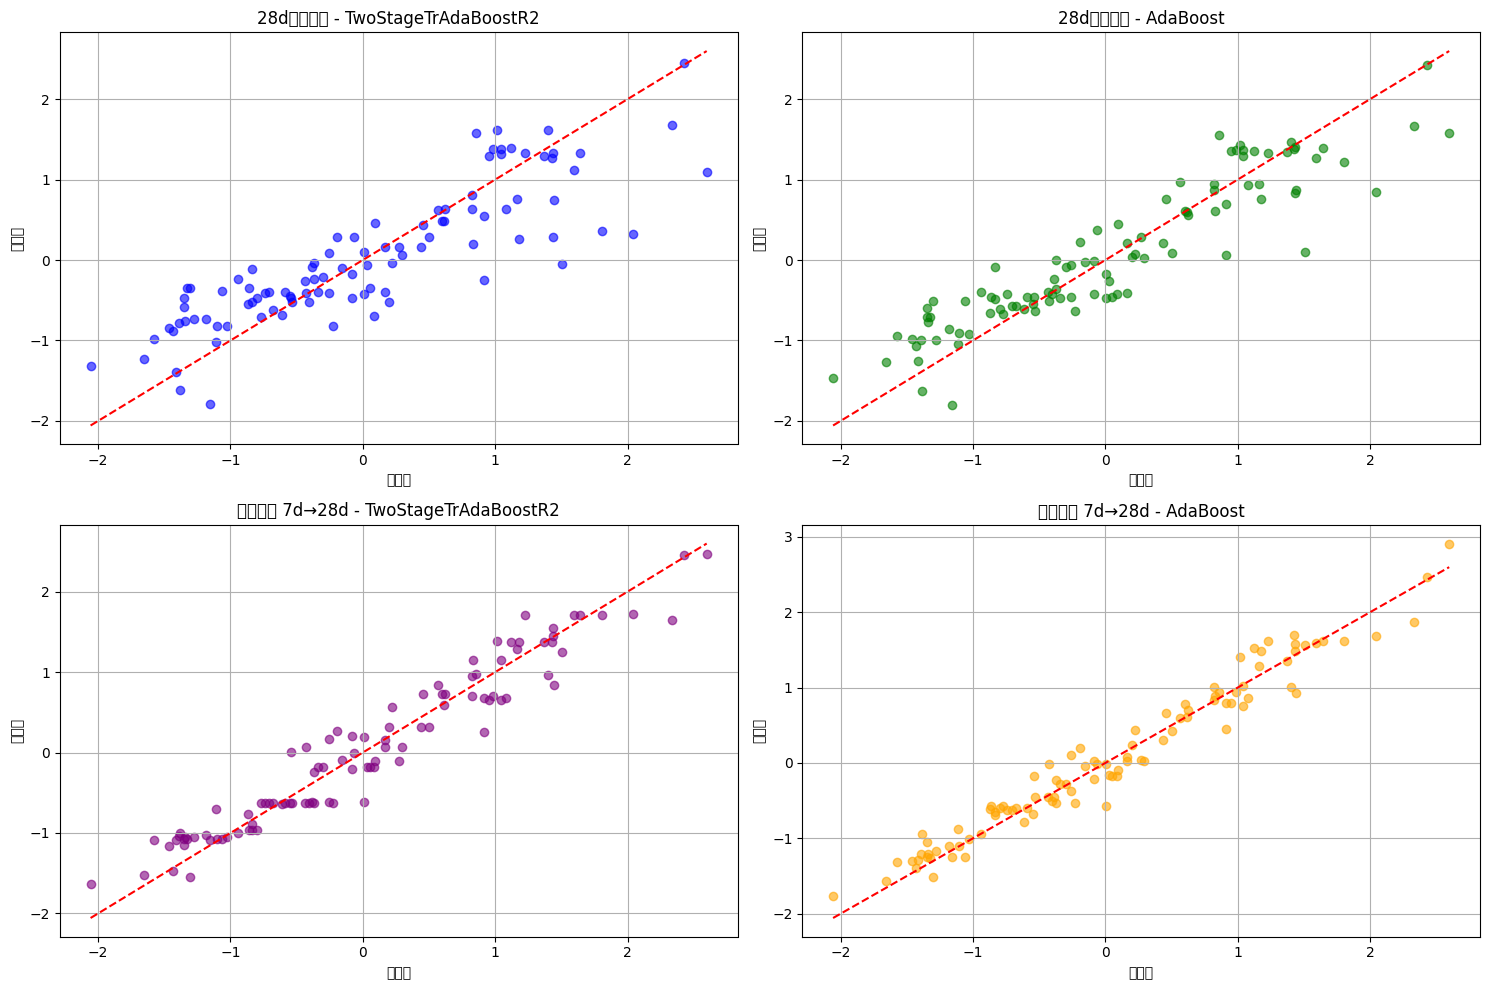


========== 测试集性能对比汇总 ==========
按RMSE升序排列的方法性能:
1. 28d迁移学习AdaBoost: RMSE = 0.2173, R² = 0.9573
2. 28d迁移学习TrAdaBoost: RMSE = 0.2699, R² = 0.9341
3. 28d直接预测AdaBoost: RMSE = 0.4183, R² = 0.8417
4. 28d直接预测TrAdaBoost: RMSE = 0.5432, R² = 0.7330


In [9]:
# Cell 9: 在测试集上进行最终预测
print("\n在测试集上进行预测...")

# 检查是否有7d强度数据可用于测试集
has_7d_in_test = '7d抗压强度' in test_df.columns

# 预测测试集上的7d强度(如果没有实际值)
if not has_7d_in_test:
    print("测试集没有7d强度数据，使用模型进行预测...")
    y_7d_test_pred = model_7d.predict(X_test_final)
else:
    print("从测试集获取7d强度数据...")
    y_7d_test_pred = test_df['7d抗压强度'].values

# 准备测试集的迁移学习特征
X_test_transfer = np.column_stack([X_test_final, y_7d_test_pred.reshape(-1, 1)])
print(f"测试集迁移学习特征形状: {X_test_transfer.shape}")

# 使用所有可用方法预测测试集的28d强度
print("\n使用不同方法预测测试集28d强度...")

# 1. 直接使用28d模型
y_28d_test_direct = model_28d.predict(X_test_final)

# 2. 使用AdaBoost 28d模型
y_28d_test_adaboost = adaboost_28d.predict(X_test_final)

# 3. 使用迁移学习模型
y_28d_test_transfer = model_transfer.predict(X_test_transfer)

# 4. 使用AdaBoost迁移学习模型
y_28d_test_transfer_adaboost = adaboost_transfer.predict(X_test_transfer)

# 如果测试集有28d实际值，评估性能
if y_28d_test_final is not None:
    print("\n测试集性能评估:")
    metrics_test_direct = evaluate_model(y_28d_test_final, y_28d_test_direct, "28d直接预测TrAdaBoost模型(测试集)")
    metrics_test_adaboost = evaluate_model(y_28d_test_final, y_28d_test_adaboost, "28d直接预测AdaBoost模型(测试集)")
    metrics_test_transfer = evaluate_model(y_28d_test_final, y_28d_test_transfer, "28d迁移学习TrAdaBoost模型(测试集)")
    metrics_test_transfer_adaboost = evaluate_model(y_28d_test_final, y_28d_test_transfer_adaboost, "28d迁移学习AdaBoost模型(测试集)")
    
    # 可视化测试集预测结果
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.scatter(y_28d_test_final, y_28d_test_direct, c='blue', alpha=0.6)
    plt.plot([min(y_28d_test_final), max(y_28d_test_final)], [min(y_28d_test_final), max(y_28d_test_final)], 'r--')
    plt.xlabel('实际值')
    plt.ylabel('预测值')
    plt.title('28d直接预测 - TwoStageTrAdaBoostR2')
    plt.grid(True)
    
    plt.subplot(2, 2, 2)
    plt.scatter(y_28d_test_final, y_28d_test_adaboost, c='green', alpha=0.6)
    plt.plot([min(y_28d_test_final), max(y_28d_test_final)], [min(y_28d_test_final), max(y_28d_test_final)], 'r--')
    plt.xlabel('实际值')
    plt.ylabel('预测值')
    plt.title('28d直接预测 - AdaBoost')
    plt.grid(True)
    
    plt.subplot(2, 2, 3)
    plt.scatter(y_28d_test_final, y_28d_test_transfer, c='purple', alpha=0.6)
    plt.plot([min(y_28d_test_final), max(y_28d_test_final)], [min(y_28d_test_final), max(y_28d_test_final)], 'r--')
    plt.xlabel('实际值')
    plt.ylabel('预测值')
    plt.title('迁移学习 7d→28d - TwoStageTrAdaBoostR2')
    plt.grid(True)
    
    plt.subplot(2, 2, 4)
    plt.scatter(y_28d_test_final, y_28d_test_transfer_adaboost, c='orange', alpha=0.6)
    plt.plot([min(y_28d_test_final), max(y_28d_test_final)], [min(y_28d_test_final), max(y_28d_test_final)], 'r--')
    plt.xlabel('实际值')
    plt.ylabel('预测值')
    plt.title('迁移学习 7d→28d - AdaBoost')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('test_predictions_comparison.png')
    plt.show()
    
    # 汇总测试集性能
    print("\n========== 测试集性能对比汇总 ==========")
    methods = [
        ("28d直接预测TrAdaBoost", metrics_test_direct),
        ("28d直接预测AdaBoost", metrics_test_adaboost),
        ("28d迁移学习TrAdaBoost", metrics_test_transfer),
        ("28d迁移学习AdaBoost", metrics_test_transfer_adaboost)
    ]
    
    # 按RMSE排序
    methods.sort(key=lambda x: x[1]['rmse'])
    
    # 打印排序后结果
    print("按RMSE升序排列的方法性能:")
    for i, (method_name, metrics) in enumerate(methods):
        print(f"{i+1}. {method_name}: RMSE = {metrics['rmse']:.4f}, R² = {metrics['r2']:.4f}")

else:
    print("测试集没有28d强度实际值，无法评估预测性能。保存预测结果...")
    
    # 创建结果DataFrame
    results_df = pd.DataFrame({
        '28d_TrAdaBoost_直接预测': y_28d_test_direct,
        '28d_AdaBoost_直接预测': y_28d_test_adaboost,
        '28d_TrAdaBoost_迁移学习': y_28d_test_transfer,
        '28d_AdaBoost_迁移学习': y_28d_test_transfer_adaboost
    })
    
    # 保存预测结果
    results_df.to_csv('28d_predictions.csv', index=False)
    print("预测结果已保存至 '28d_predictions.csv'")



通过模型融合生成最终预测...
基于R²的融合权重: [0.21148988 0.242835   0.2694953  0.27617982]

融合模型性能评估:
融合模型(测试集) 性能评估:
MSE: 0.0823
RMSE: 0.2869
MAE: 0.2279
R²: 0.9255


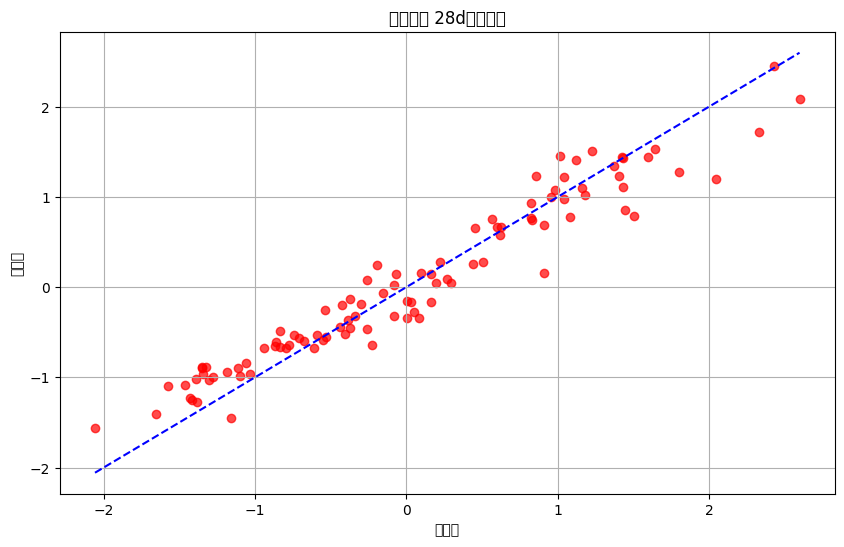


========== 更新测试集性能对比汇总 ==========
按RMSE升序排列的方法性能:
1. 28d迁移学习AdaBoost: RMSE = 0.2173, R² = 0.9573
2. 28d迁移学习TrAdaBoost: RMSE = 0.2699, R² = 0.9341
3. 融合模型: RMSE = 0.2869, R² = 0.9255
4. 28d直接预测AdaBoost: RMSE = 0.4183, R² = 0.8417
5. 28d直接预测TrAdaBoost: RMSE = 0.5432, R² = 0.7330

所有预测结果(含融合模型)已保存至 '28d_predictions_with_ensemble.csv'

保存训练好的模型...
模型已保存至 'concrete_strength_models.pkl'

========== 分析完成 ==========


In [10]:
# Cell 10: 建立模型融合方法并生成最终预测
print("\n通过模型融合生成最终预测...")

# 模型融合权重 (这些权重可以通过交叉验证等方法更精确地确定)
# 权重顺序: [TrAdaBoost直接, AdaBoost直接, TrAdaBoost迁移, AdaBoost迁移]
if y_28d_test_final is not None:
    # 如果有测试集实际值，使用测试性能调整权重
    methods = [
        ("28d直接预测TrAdaBoost", metrics_test_direct),
        ("28d直接预测AdaBoost", metrics_test_adaboost),
        ("28d迁移学习TrAdaBoost", metrics_test_transfer),
        ("28d迁移学习AdaBoost", metrics_test_transfer_adaboost)
    ]
    
    # 根据每种方法的R²值计算权重 (更高的R²值获得更高权重)
    r2_values = np.array([metrics['r2'] for _, metrics in methods])
    
    # 确保所有R²值为正，否则给负值赋予很小的权重
    r2_values = np.maximum(r2_values, 0.01)
    
    # 计算权重
    weights = r2_values / np.sum(r2_values)
    print(f"基于R²的融合权重: {weights}")
else:
    # 如果没有测试集实际值，使用默认权重
    weights = np.array([0.3, 0.2, 0.35, 0.15])  # 默认权重，偏向迁移学习TrAdaBoost
    print(f"默认融合权重: {weights}")

# 生成融合预测
all_predictions = np.column_stack([
    y_28d_test_direct, 
    y_28d_test_adaboost, 
    y_28d_test_transfer, 
    y_28d_test_transfer_adaboost
])

y_28d_test_ensemble = np.sum(all_predictions * weights, axis=1)

# 如果有测试集实际值，评估融合模型性能
if y_28d_test_final is not None:
    print("\n融合模型性能评估:")
    metrics_ensemble = evaluate_model(y_28d_test_final, y_28d_test_ensemble, "融合模型(测试集)")
    
    # 可视化融合模型预测
    plt.figure(figsize=(10, 6))
    plt.scatter(y_28d_test_final, y_28d_test_ensemble, c='red', alpha=0.7)
    plt.plot([min(y_28d_test_final), max(y_28d_test_final)], [min(y_28d_test_final), max(y_28d_test_final)], 'b--')
    plt.xlabel('实际值')
    plt.ylabel('预测值')
    plt.title('融合模型 28d强度预测')
    plt.grid(True)
    plt.savefig('ensemble_prediction.png')
    plt.show()
    
    # 将融合结果加入汇总
    print("\n========== 更新测试集性能对比汇总 ==========")
    methods.append(("融合模型", metrics_ensemble))
    
    # 按RMSE排序
    methods.sort(key=lambda x: x[1]['rmse'])
    
    # 打印排序后结果
    print("按RMSE升序排列的方法性能:")
    for i, (method_name, metrics) in enumerate(methods):
        print(f"{i+1}. {method_name}: RMSE = {metrics['rmse']:.4f}, R² = {metrics['r2']:.4f}")

# 在任何情况下都保存融合预测结果
results_with_ensemble_df = pd.DataFrame({
    '28d_TrAdaBoost_直接预测': y_28d_test_direct,
    '28d_AdaBoost_直接预测': y_28d_test_adaboost,
    '28d_TrAdaBoost_迁移学习': y_28d_test_transfer,
    '28d_AdaBoost_迁移学习': y_28d_test_transfer_adaboost,
    '28d_融合预测': y_28d_test_ensemble
})

results_with_ensemble_df.to_csv('28d_predictions_with_ensemble.csv', index=False)
print("\n所有预测结果(含融合模型)已保存至 '28d_predictions_with_ensemble.csv'")

# 保存训练好的模型
import pickle

print("\n保存训练好的模型...")
models = {
    '7d_model': model_7d,
    '28d_model': model_28d,
    'transfer_model': model_transfer,
    '7d_adaboost': adaboost_7d,
    '28d_adaboost': adaboost_28d,
    'transfer_adaboost': adaboost_transfer,
    'ensemble_weights': weights
}

with open('concrete_strength_models.pkl', 'wb') as f:
    pickle.dump(models, f)

print("模型已保存至 'concrete_strength_models.pkl'")
print("\n========== 分析完成 ==========")
